In [1]:
%matplotlib inline
%precision 3

import montecarlo
import plot
import metrics
from decimal import Decimal
import simulate
import pandas
from pprint import pprint
import metrics
import withdrawal
import harvesting
import mortality

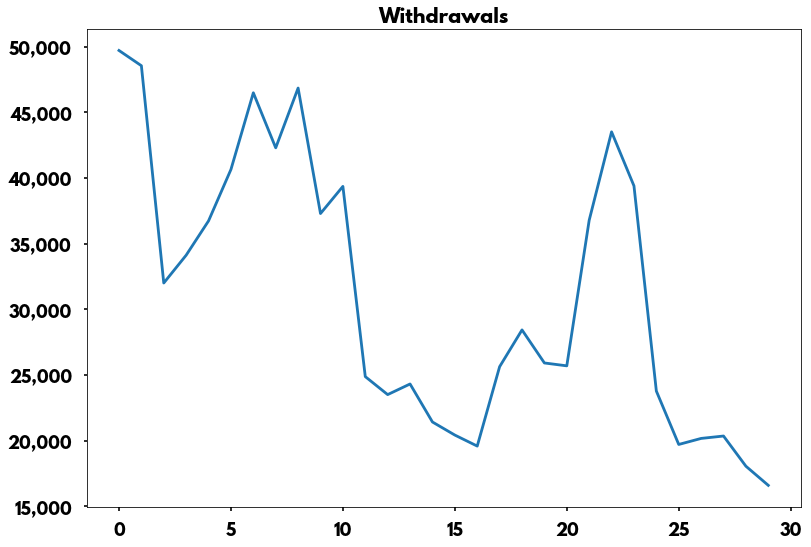

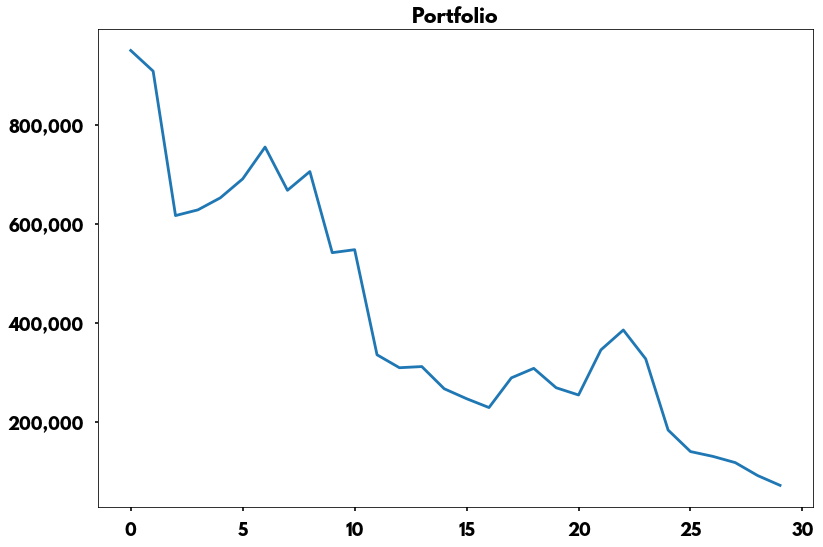

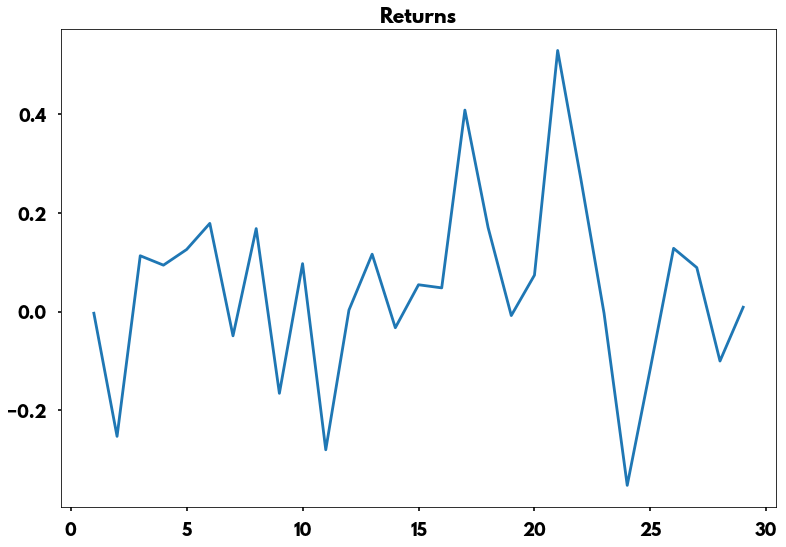

In [2]:
r = simulate.withdrawals(montecarlo.LowYieldsAutoRegression(), years=30, withdraw=withdrawal.VPW)
plot.plot([n.withdraw_r for n in r], title='Withdrawals')
plot.plot([n.portfolio_r for n in r], title='Portfolio')
plot.plot([n.returns for n in r], title='Returns', add_commas=False, zero_based=False)

In [3]:
pprint(['%.2f' % float(n.returns) for n in r[1:]])

['-0.00',
 '-0.25',
 '0.11',
 '0.09',
 '0.13',
 '0.18',
 '-0.05',
 '0.17',
 '-0.17',
 '0.10',
 '-0.28',
 '0.00',
 '0.12',
 '-0.03',
 '0.05',
 '0.05',
 '0.41',
 '0.17',
 '-0.01',
 '0.07',
 '0.53',
 '0.27',
 '-0.00',
 '-0.35',
 '-0.11',
 '0.13',
 '0.09',
 '-0.10',
 '0.01']


In [4]:
def harness(iters, sim):
    successes = 0
    incomes = pandas.Series(iters)
    for i in range(iters):
        sim_results = sim()
        incomes.loc[i] = float(metrics.cew([(n.withdraw_pct_orig * 100) + Decimal('.01') for n in sim_results]))
        if sim_results[-1].portfolio_n > 0:
            successes += 1
    return (successes/iters, incomes)

def p_q(incomes):
    print('90th percentile income', incomes.quantile(.9))
    print('50th percentile income', incomes.quantile(.5))
    print('10th percentile income', incomes.quantile(.1))
    print('5th percentile income', incomes.quantile(.05))
    print('1st percentile income', incomes.quantile(.01))   

In [5]:
iters = 50
EM = harness(iters, lambda: simulate.withdrawals(montecarlo.LowYieldsHighValuations(), years=30))
VPW = harness(iters, lambda: simulate.withdrawals(montecarlo.LowYieldsHighValuations(),harvesting=harvesting.N_60_RebalanceHarvesting, withdraw=withdrawal.VPW, years=30))
#ECM = harness(iters, lambda: simulate.withdrawals(montecarlo.LowYieldsAutoRegression(), withdraw=withdrawal.ECM, years=30))
VG = harness(iters, lambda: simulate.withdrawals(montecarlo.LowYieldsHighValuations(), withdraw=withdrawal.Vanguard, years=30))

In [6]:
for i in (EM, VG, VPW):
    print('Success rate', i[0])
    p_q(i[1])
    print()

Success rate 0.7
90th percentile income 4.094097087663272
50th percentile income 2.8648425275111578
10th percentile income 0.014896956830963282
5th percentile income 0.01333007677081503
1st percentile income 0.012582779902490241

Success rate 0.46
90th percentile income 3.294233904811
50th percentile income 0.01873134538011001
10th percentile income 0.012574334295128586
5th percentile income 0.012098967349799372
1st percentile income 0.011993449872631817

Success rate 1.0
90th percentile income 4.627161375586194
50th percentile income 2.6041051927014855
10th percentile income 1.2207194926655038
5th percentile income 1.064242065081067
1st percentile income 0.9646303546661698



In [7]:
def run_one(years, stock_pct, a=None):
    bond_pct = (1 - stock_pct)
    
    if not a:
        a = montecarlo.LowYieldsAutoRegression(initial_yield=.025)
    
    returns = []
    
    for i, j in zip(range(years+1), a):
        stocks = float(j.stocks - j.inflation)
        bonds = float(j.bonds - j.inflation)
        total_return = (stocks * stock_pct) + (bonds * bond_pct)
        returns.append(total_return)
    return returns

In [8]:
a = montecarlo.LowYieldsAutoRegression(initial_yield=.025, logging=True)
run_one(30, .6, a=a)
print('inflation', a.log['inflation'].mean())
print('stocks', a.log['stocks'].mean())
print('bonds', a.log['bonds'].mean())
print('-' * 65)
print(a.log)

inflation 0.021773144762884878
stocks 0.07161821125852835
bonds 0.015980007710811806
-----------------------------------------------------------------
      y_prev     y_new        rc    stocks     bonds  inflation
0   0.025000  0.020159  0.000000  0.312708  0.049008  -0.027430
1   0.020159  0.014984  0.000000  0.178056  0.030496  -0.004002
2   0.014984  0.010000  0.000000  0.447521 -0.057317  -0.005513
3   0.010000  0.017964  0.000000  0.244028 -0.056559   0.034733
4   0.017964  0.010000  0.000000  0.229458  0.117046   0.043704
5   0.010000  0.019000  0.000779 -0.315710  0.067786  -0.003776
6   0.019000  0.016101  0.000000  0.317493 -0.019618   0.040344
7   0.016101  0.025069  0.008975 -0.108025 -0.008494   0.065931
8   0.025069  0.024048  0.008339 -0.083725 -0.007206   0.012927
9   0.024048  0.046397  0.023017  0.024533 -0.054279   0.056660
10  0.046397  0.059069  0.046724  0.453401  0.023301   0.012948
11  0.059069  0.045676  0.012513  0.208491  0.021647  -0.010067
12  0.045676  0.0

In [9]:
iters = 100

s = pandas.Series(iters)

for i in range(iters):
    years = 30
    stock_pct = .6
    ssr = metrics.ssr([Decimal(n) for n in run_one(years, stock_pct)])
    s[i] = float(ssr)

In [10]:
s.median()

0.052

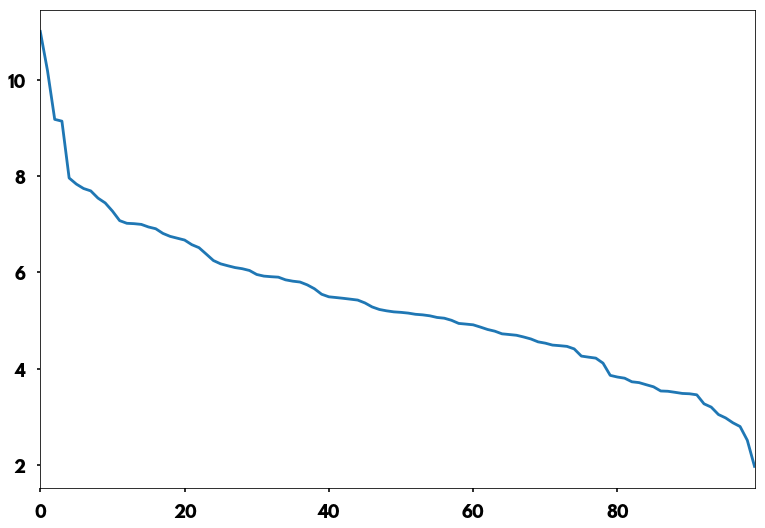

In [11]:
rates = pandas.Series(100)
for i in range(0, 100):
    q = s.quantile((100-i)/100)
    rates[i] = q * 100
rates.plot()

In [12]:
survival_fn = mortality.make_mortality(mortality.NVSS_2011)
iters = 1000
successes = 0
for i in range(iters):
    lifespan = mortality.gen_lifespan(mortality.DEFAULT_COUPLE, survival_fn=survival_fn)
    sim_results = simulate.withdrawals(montecarlo.LowYieldsAutoRegression(),
                         harvesting=harvesting.make_rebalancer(.6),
                         withdraw=withdrawal.ConstantDollar,
                         years=lifespan)
    if sim_results[-1].portfolio_n > 0:
        successes += 1
print(successes/iters)

0.853


In [27]:
survival_fn = mortality.make_mortality(mortality.NVSS_2011)
iters = 1000
successes = 0
failures = 0
years_to_failure = []
portfolio_at_10 = []
for i in range(iters):
    lifespan = mortality.gen_lifespan(mortality.DEFAULT_COUPLE, survival_fn=survival_fn)
    sim_results = simulate.withdrawals(montecarlo.LowYieldsAutoRegression(),
                         harvesting=harvesting.make_rebalancer(1),
                         withdraw=lambda p,h: withdrawal.ConstantDollar(p, h, rate=Decimal('.04')),
                         years=lifespan)

    # only count iterations where the initial 5 year return was at
    # least equal to what we've experienced.
    cumulative = pandas.Series([x.returns + 1 for x in sim_results[1:6]])
    if numpy.prod(cumulative) - 1 < 1.03660168511777: continue

    if sim_results[-1].portfolio_n > 0:
        successes += 1
    else:
        failures += 1
        years_to_failure.append(len(list(filter(lambda x: x.portfolio_r > 0, sim_results))))
        portfolio_at_10.append(sim_results[9].portfolio_r)
print(successes/(successes + failures))

0.988950276243094


In [14]:
fail = pandas.Series(years_to_failure)
len(fail[fail < 20])

43

In [15]:
p = pandas.Series(portfolio_at_10)

In [16]:
p

0      750071.2604348202206522135328
1      430860.3282306599012950499479
2      655202.3423705958148404303159
3      401174.1627041617341174820870
4      749361.6475542902397897960353
5      439151.6768034340651589092933
6      349493.8352456113794442120076
7      698119.8246200610428498517192
8      878215.2957749415491540991785
9      311734.6244645565348812023083
10     682767.8507865698811846887182
11     873008.7241803959533398897142
12     279346.6327879057247208630968
13     633340.8975660904655285581579
14     648575.8694344346224060294442
15     452566.3105914097409048092500
16     531921.8127857206151521654769
17     269032.8818028959839941657593
18     175384.5806053492465657565475
19     466982.9657529877420647758499
20     544977.6837621431614565500436
21     605988.1128225934351421429901
22     423651.4959853192613983602594
23     585327.3375322643176635179292
24     449330.7740125003097387196992
25     287719.2803937878726237264941
26     410384.8730903092744543844492
2

In [21]:
import numpy
import scipy.stats

iters = 5000
df = pandas.DataFrame(columns=numpy.arange(iters))

for i in range(iters):
    engine = montecarlo.LowYieldsAutoRegression()
    
    returns = []
    for j in range(5):
        returns.append(float(engine.random_year().stocks) + 1)
    series = pandas.Series(returns)
    
    df[i] = series

cumulative_returns = df.apply(lambda x: numpy.prod(x) - 1)

scipy.stats.percentileofscore(cumulative_returns, 1.03660168511777) # returns from 2011 - 2017 (inclusive)

82.120

In [22]:
cumulative_returns.quantile(0.5)

0.428